In [1]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm

/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /home/yannick/bin/anaconda3/envs/py27/lib/python2.7/argparse.pyc, but /home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


In [2]:
def gen_sample(n, mus, sigmas):
    return np.array([mus + stats.norm.rvs(size = n, loc = 0, scale = sigmas[i]) for i in np.arange(len(sigmas)) ])

def gen_mus_sigma(nb_stateux, nb_samples):
    return (stats.uniform.rvs(size=nb_samples, loc=0, scale=200), stats.uniform.rvs(size=nb_stateux, loc=0, scale=40))

nb_stateux = 7
sample_length = 1

(mus, sigma) = gen_mus_sigma(nb_stateux, sample_length)
sample = gen_sample(sample_length, mus, sigma)
print len(sample), len(sample[0])
print mus
print sigma
print sample
print [np.mean([sample[i, j] for i in np.arange(len(sigma))]) for j in np.arange(len(mus))]

print sample.shape

7 1
[ 5.89262951]
[  4.47806648   2.71552582  37.13113608  37.82667901   0.34623891
  18.50638226  26.06658268]
[[ 10.30009975]
 [  6.45443797]
 [-13.41454834]
 [ -6.95716612]
 [  5.50843321]
 [ 30.09814987]
 [ 11.86700429]]
[6.2652015186674106]
(7, 1)


In [3]:
import numpy as np
import pymc as pm

(nb_stateux, sample_length) = sample.shape

v_mus = np.array([pm.Normal("mu%d" % i, mu=0, tau=0.001) for i in np.arange(sample_length)])
v_sigmas = [pm.Uniform("sigma%d" % k, lower=0, upper=100) for k in np.arange(nb_stateux)]
v_taus = [pm.Lambda("tau%d" % k, lambda sigma=v_sigmas[k]: 1/sigma**2) for k in np.arange(nb_stateux)]

x = np.array([[pm.Normal("x%d_%d" % (k,i), mu=v_mus[i], tau=v_taus[k], 
                         observed=True, value=np.array(sample[k,i])) for i in np.arange(sample_length)]
              for k in np.arange(nb_stateux)])

mcmc = pm.MCMC([v_mus, v_sigmas, v_taus, x])
mcmc.sample(5000,1000)

mu_traces = [np.array(mcmc.trace('mu%d' % k)[:]) for k in np.arange(sample_length)]
sigma_traces = [np.array(mcmc.trace("sigma%d" % i)[:]) for i in np.arange(nb_stateux)]

 [-----------------100%-----------------] 5000 of 5000 complete in 1.6 sec

In [4]:
%history -f 7stateux_model.py -l 1

File u'7stateux_model.py' exists. Overwrite? y
Overwriting file.


6.72277478084


/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


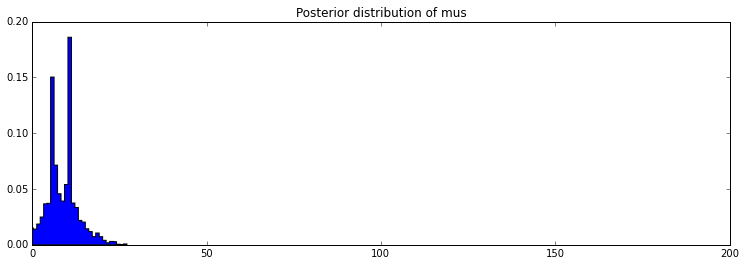

In [5]:
figsize(12.5, 4)
plt.title("Posterior distribution of mus")
for i in np.arange(sample_length):
    plt.hist(mu_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,200))
    print (mu_traces[i].mean())

26.6794071899
30.8075794381
45.352531068
40.115170272
26.8489026427
46.8058219254
30.7458513845


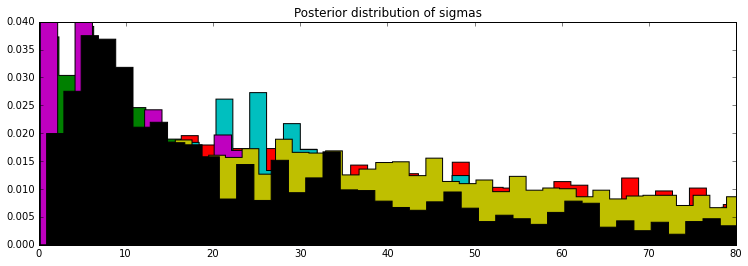

In [6]:
figsize(12.5, 4)
plt.title("Posterior distribution of sigmas")
for i in np.arange(nb_stateux):
    plt.hist(sigma_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,80))
    print (sigma_traces[i].mean())

In [7]:
# Now going parallel

from IPython.parallel import Client
client = Client()

direct         = client[:]
direct.block   = True
print (direct)

def checkhostname():
    import socket
    return socket.gethostname()

direct.apply(checkhostname)

import numpy as np
with direct.sync_imports():
    import pymc as pm
    import numpy as np

<DirectView [0, 1, 2, 3,...]>
importing pymc on engine(s)
importing numpy on engine(s)


In [8]:
export_dict = {k: globals()[k] for k in ('sample', 'nb_stateux')}
direct.push(export_dict, block=True)

model_script = open('7stateux_model.py').read()
print model_script

import numpy as np
import pymc as pm

(nb_stateux, sample_length) = sample.shape

v_mus = np.array([pm.Normal("mu%d" % i, mu=0, tau=0.001) for i in np.arange(sample_length)])
v_sigmas = [pm.Uniform("sigma%d" % k, lower=0, upper=100) for k in np.arange(nb_stateux)]
v_taus = [pm.Lambda("tau%d" % k, lambda sigma=v_sigmas[k]: 1/sigma**2) for k in np.arange(nb_stateux)]

x = np.array([[pm.Normal("x%d_%d" % (k,i), mu=v_mus[i], tau=v_taus[k], 
                         observed=True, value=np.array(sample[k,i])) for i in np.arange(sample_length)]
              for k in np.arange(nb_stateux)])

mcmc = pm.MCMC([v_mus, v_sigmas, v_taus, x])
mcmc.sample(5000,1000)

mu_traces = [np.array(mcmc.trace('mu%d' % k)[:]) for k in np.arange(sample_length)]
sigma_traces = [np.array(mcmc.trace("sigma%d" % i)[:]) for i in np.arange(nb_stateux)]



In [9]:
direct.execute(model_script)

<AsyncResult: finished>

In [10]:
def get_trace(var_name):
    all_traces = direct.pull(var_name)
    a = len(all_traces)
    b = len(all_traces[0])

    y = [np.array([all_traces[i][j] for i in range(a)]).flatten() for j in range(b)]
    
    return y

mu_traces = get_trace("mu_traces")
sigma_traces = get_trace("sigma_traces")

print mu_traces
print len(mu_traces), len(mu_traces[0])

[array([ 2.20807609,  2.20807609,  2.20807609, ...,  7.78806055,
        7.78806055,  2.39769789])]
1 32000


6.04907308029 5.8926295068


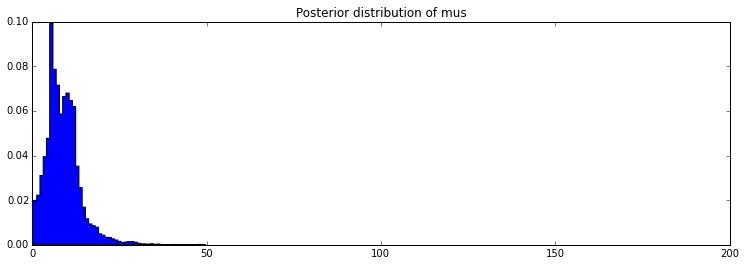

In [11]:
figsize(12.5, 4)
plt.title("Posterior distribution of mus")
for i in np.arange(sample_length):
    plt.hist(mu_traces[i], bins=100, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,200))
    print (mu_traces[i].mean()), mus[i]

(31.624790094205398, 22.706670373354271, 4.4780664752671706)
(29.72518097771302, 20.455281275094173, 2.7155258180754682)
(44.849161024275027, 40.305405940419043, 37.131136081135871)
(39.775426593556226, 34.075750413554076, 37.826679014596927)
(29.785528838197134, 20.768262591492054, 0.34623890711255711)
(47.775745979531521, 43.603943872950438, 18.506382259785347)
(29.959334396534196, 21.105989108075008, 26.066582683792756)


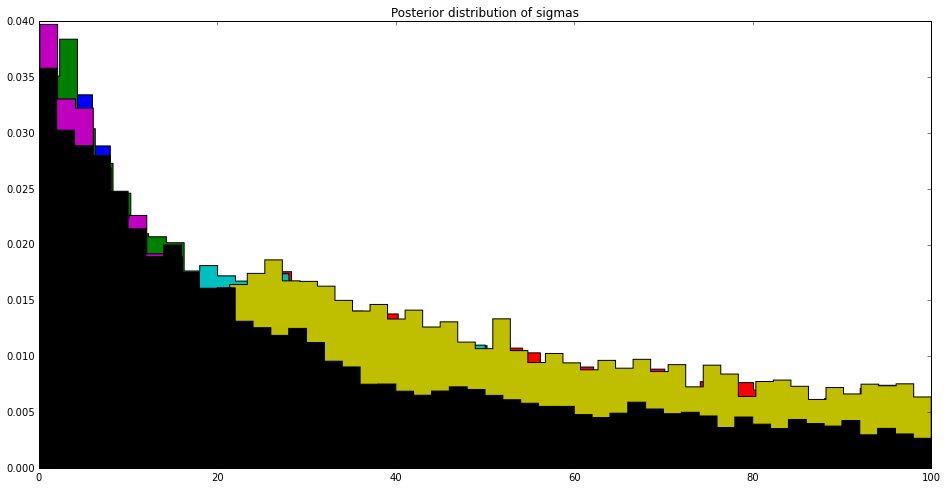

In [12]:
figsize(16, 8)
plt.title("Posterior distribution of sigmas")
for i in np.arange(nb_stateux):
    plt.hist(sigma_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,100))
    print (sigma_traces[i].mean(), np.median(sigma_traces[i]), sigma[i])